## Decision Tree Classification models to predict employee turnover

In this project I have attempted to create supervised learning models to assist in classifying certain employee data. The classes to predict are as follows:
* Active - the employee is still in their role
* Non-active - the employee has resigned

I pre-processed the data by removing one outlier and producing new features in Excel as the data set was small at 1056 rows. Some categorical features were also converted to numeric values in Excel. For example, Gender was originally "M" or "F", which was converted to 0 and 1 respectively. I also removed employee number as it provides no value as a feature and could compromise privacy. 

After doing some research, see References, I found that the scikit-learn library does not handle categorical (string) features correctly in Decision Trees using the above approach. When added, these features provided no increase in accuracy, so I removed them. For example; *Department*, some departments have a higher turnover, but this could be because more people work in that department. To get around this issue I created a feature called *Dept_Ratio*, which is the turnover ratio per department. This increased accuracy marginally and was more noticeable in the Random Forest classifier.

The focus here is on splitting the data, feature importance, training classifiers and reviewing results via a basic accuracy function and confusion matrices. Some code structures were based on a Coursera MOOC called [Data-driven Astronomy](https://www.coursera.org/learn/data-driven-astronomy/home/welcome) by The University of Sydney and subsequently modified for my purposes. I had not come across confusion matrices before, so this course was handy for this and practising working with numpy arrays.

Note: I originally read the data into a dataframe, however because the data was clean already, I decided on just trying out **genfromtxt** to load the data directly into a numpy array.

In [97]:
# Perform necessary imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%pylab inline

# Imports related to classifiers
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import cross_val_predict
from sklearn.ensemble import RandomForestClassifier

# Imports related to confusion matrix
from sklearn.tree import export_graphviz
import pydotplus as pydotplus
from sklearn.externals.six import StringIO  
from IPython.display import Image  

# Support functions import
from support_functions import calculate_accuracy, plot_confusion_matrix

Populating the interactive namespace from numpy and matplotlib


In [84]:
# Load csv data into numpy array, skip header row and specify data types.
# note: when I used 'S10' for Class, I got a 'b' in front of each Class, i.e. b'Active' - using 'U10' avoided this.
data = np.genfromtxt("emp_turnover.csv", delimiter=',', skip_header=1,
                     dtype={'names': ('Tenure', 'Age', 'Category', 'Gender', 'Department', 'Dept_Ratio', 'Amount', 'Class'),
                            'formats': ('i4', 'i4', 'i4', 'i4', 'i4', 'f8', 'f8', 'U10')})

I think it is important to understand the structure of the data, particularly as I'm used to working with dataframes.

In [85]:
# View the shape and first five rows of array to get a better feel for the data.
print (data.shape)
data[:5]

(1056,)


array([(1958, 32, 0, 0, 13,  0.006,  39.3733, 'Non-active'),
       (3894, 61, 1, 1, 28,  0.046,  23.0003, 'Non-active'),
       (1672, 22, 2, 0, 17,  0.03 ,  21.3228, 'Non-active'),
       (1116, 30, 2, 1, 27,  0.012,  21.3228, 'Non-active'),
       (1795, 24, 2, 0, 21,  0.014,  28.339 , 'Non-active')],
      dtype=[('Tenure', '<i4'), ('Age', '<i4'), ('Category', '<i4'), ('Gender', '<i4'), ('Department', '<i4'), ('Dept_Ratio', '<f8'), ('Amount', '<f8'), ('Class', '<U10')])

Use Seaborn's pair plot to review the relationships between the original numeric features. Note: Category, Gender and Department have been converted to simple numeric features for machine learning techniques. Department has been ignored because all algorithms generated a higher score without it. 
There appears to be a somewhat weak positive relationship between Tenure and Age. There doesn't seem to be any relationship between Amount and Tenure, so people on higher hourly rates are not staying longer.
The vast majority of employees are young, with older employees staying longer.

   Tenure  Age  Category  Gender  Department  Dept_Ratio   Amount       Class
0    1958   32         0       0          13       0.006  39.3733  Non-active
1    3894   61         1       1          28       0.046  23.0003  Non-active
2    1672   22         2       0          17       0.030  21.3228  Non-active
3    1116   30         2       1          27       0.012  21.3228  Non-active
4    1795   24         2       0          21       0.014  28.3390  Non-active


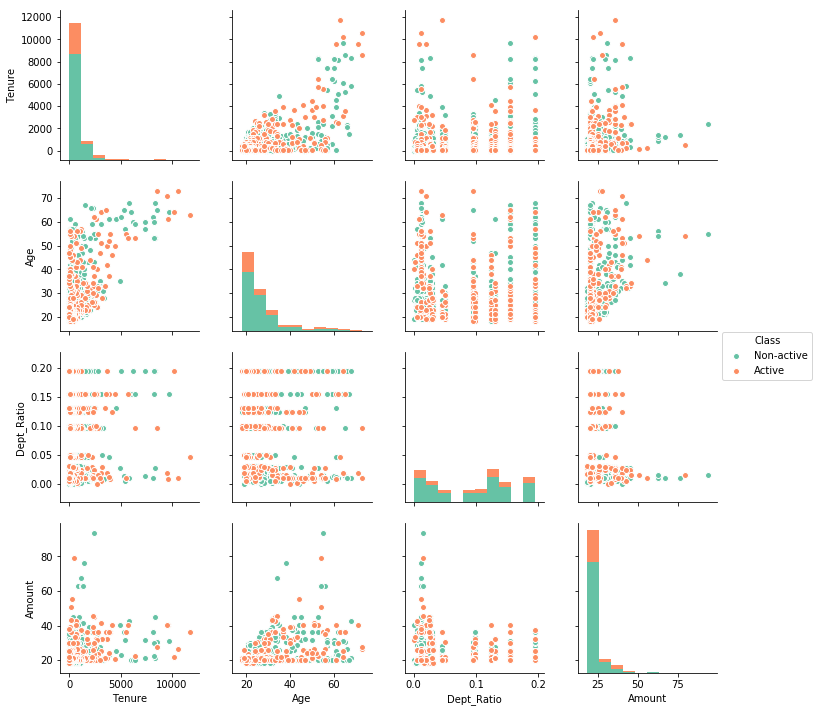

In [86]:
# Generate a dataframe and pair plot to quickly see what the original numberic fields look like.
df = pd.read_csv('emp_turnover.csv')
# Review first five rows of the dataframe
print (df.head())
# Generate pair plot
sns.pairplot(df.dropna(), vars=['Tenure', 'Age', 'Dept_Ratio', 'Amount'], hue='Class', palette="Set2");

Try a decision tree classifier with a basic approach to splitting training data, initially as a fraction.

The advantage of decision trees are that they are simple and therefore easily interpretable for people like me who are starting out on their Machine Learning journey of discovery! 

In [87]:
# Set the fraction of data which should be in the training set
fraction_training = 0.70

# Function to split training & testing data via the above fraction
def splitdata_train_test(data, fraction_training):
    # shuffle the numpy array
    np.random.seed(0)
    np.random.shuffle(data)
    split = int(len(data)*fraction_training)
    return data[:split], data[split:]

# Function to generate features and targets from data array.
def generate_features_targets(data):
    # assign the last column 'Class' to targets
    targets = data['Class']
    # assign selected columns to features
    features = np.empty(shape=(len(data), 4))
    features[:, 0] = data['Tenure']
    features[:, 1] = data['Age'] 
    features[:, 2] = data['Dept_Ratio'] # feature calculated in csv file via Excel
    features[:, 3] = data['Amount']
        
    return features, targets

# Function to split the data and train a decision tree classifier
def dtc_predict_actual(data):
    # split the data into training and testing sets using a training fraction of 0.7
    train, test = splitdata_train_test(data, fraction_training)

    # generate the feature and targets for the training and test sets
    # i.e. train_features, train_targets, test_features, test_targets
    train_features, train_targets = generate_features_targets(train)
    test_features, test_targets = generate_features_targets(test)

    # instantiate a decision tree classifier
    dtc = DecisionTreeClassifier()

    # train the classifier with the train_features and train_targets
    dtc.fit(train_features, train_targets)

    # get predictions for the test_features
    predictions = dtc.predict(test_features)

    # return the predictions and the test_targets
    return predictions, test_targets


# Call the dtc_predict_actual function and pass data
predicted_class, actual_class = dtc_predict_actual(data)


# calculate the model score using our support function
model_score = calculate_accuracy(predicted_class, actual_class)
print("Our accuracy score:", model_score)

# Print some initial results
print("Some initial results...\n   predicted,  actual")
for i in range(10):
    print("{}. {}, {}".format(i, predicted_class[i], actual_class[i]))
    

Our accuracy score: 0.738170347003
Some initial results...
   predicted,  actual
0. Non-active, Active
1. Active, Non-active
2. Non-active, Non-active
3. Non-active, Non-active
4. Non-active, Non-active
5. Non-active, Non-active
6. Non-active, Non-active
7. Non-active, Non-active
8. Non-active, Non-active
9. Active, Active


The Decision Tree has done a reasonable job, considering there is not really a large array of high quality features/variables to choose from.

In [88]:
# Use ExtraTreesClassifier to determine feature importance, so it can be compared to the decision tree structure

X, Y = generate_features_targets(data)
# feature extraction
model = ExtraTreesClassifier()
model.fit(X, Y)
print (model.feature_importances_)

[ 0.49987691  0.21529859  0.14596752  0.13885699]


The feature order of importance is from largest to smallest; *Tenure*, *Age*, followed by either *Dept_Ratio* or *Amount*, which are similar in importance.

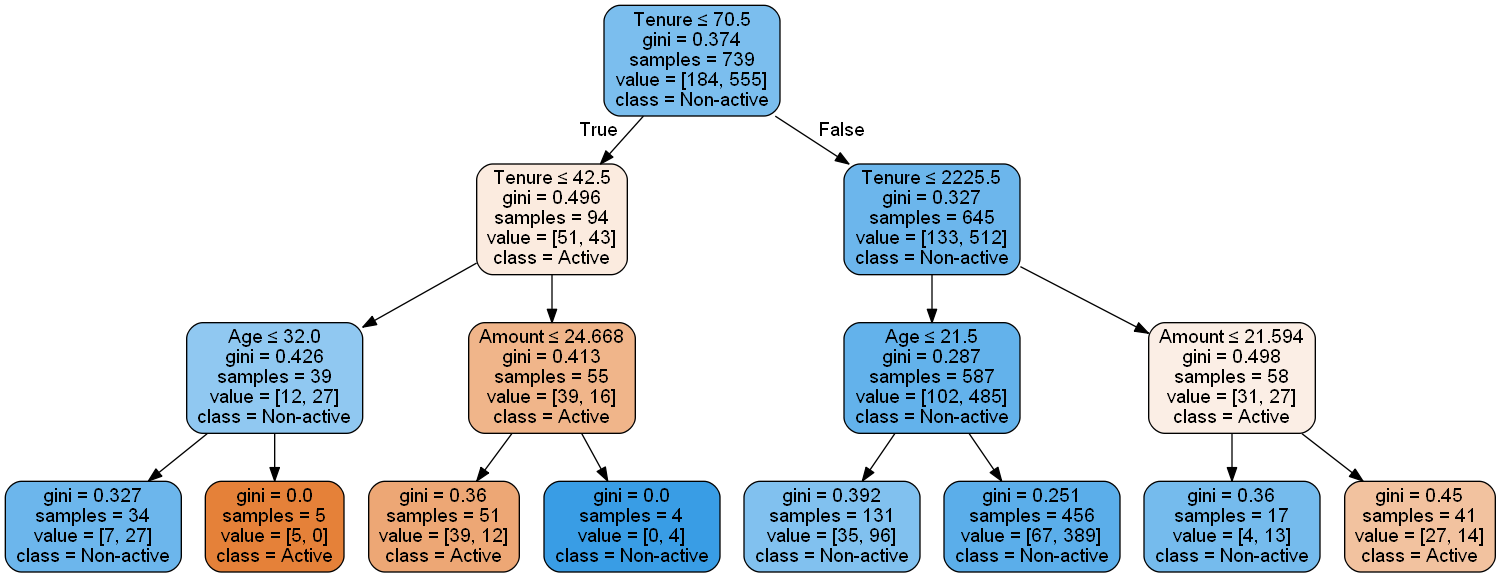

In [99]:
# split the data into training and testing sets as per above code cell method
train, test = splitdata_train_test(data, fraction_training)

# generate the feature and targets for the training and test sets
train_features, train_targets = generate_features_targets(train)
test_features, test_targets = generate_features_targets(test)

# Create a new decision tree classifier with limited depth and fit
dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(train_features, train_targets)

# Use graphviz, pydotplus to view the decision tree
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data, filled=True, rounded=True, special_characters=True, 
               feature_names=['Tenure', 'Age', 'Dept_Ratio', 'Amount'], class_names=list(set(train_targets)))
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())
#graph.write_jpg("decision_tree_sample.jpg")

One of the biggest advantages of using Decision Trees is the ease with which we can see what features or variables contribute to the classification and their relative importance based on their location depthwise in the tree. Features at the root (top) of the tree are considered more important for decision making. *Tenure* is consistently at the top, indicating that it is the most useful feature. This aligns to the Extra Trees model above and is intuitive because the *Tenure* feature showed a clearer relationship in the previous scatter plots.

To summarise what the decision tree does in pseudocode:
1. Place the best feature of our dataset at the root of the tree (*Tenure* in our example).
2. Split the training set into subsets. Subsets should be made in such a way that each subset contains data with the same value for an attribute.
3. Repeat step 1 and step 2 on each subset until you find leaf nodes in all the branches of the tree.

In the above decision tree example, I have set the depth to 3, so it is possible get an understanding of how the decision tree is calculated. If the Decision Tree was based on maximum depth set to None (default), then nodes are expanded until all leaves are pure which would be too complex to review, or even read, without zooming in on only a part of the tree. 

Note: the above tree will change each time it is run, due to the random shuffle approach in the *splitdata_train_test* function.

Samples are gradually broken down via a sequence of decisions until there is a leaf node (containing only a single sample, [gini](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) = 0.0). Sometimes when I run the above tree at a depth of 3, I can see a leaf node or two. The number of samples above is 739, which is the full data set 1056 multiplied by the training fraction of 0.7. 

> In the references at the end there is a clear decision tree example (YouTube) which utilises graphviz & iris dataset if you are interested.

Use the decision tree classifier again with cross validation, rather than a manual fraction.

Our accuracy score: 0.805871212121
Confusion matrix, without normalization
[[113 138]
 [ 67 738]]


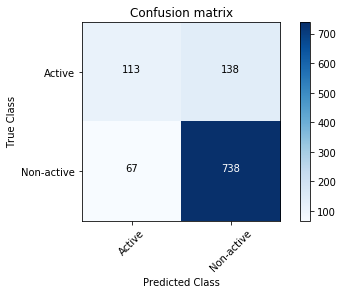

In [90]:
from sklearn import metrics

# Call function to generate features and targets
features, targets = generate_features_targets(data)

# get predictions using 10-fold cross validation with cross_val_predict
dtc = DecisionTreeClassifier(max_depth=4, criterion='entropy')
predicted = cross_val_predict(dtc, features, targets, cv=10)

# calculate the model score using support function
model_score = calculate_accuracy(predicted, targets)
print("Our accuracy score:", model_score)

# calculate the models confusion matrix using sklearns confusion_matrix function
class_labels = list(set(predicted))
model_cm = confusion_matrix(y_true=targets, y_pred=predicted, labels=class_labels)

# Plot the confusion matrix using the provided functions.

plt.figure()
plot_confusion_matrix(model_cm, classes=class_labels)
plt.savefig('dt_confusion_matrix.png')
plt.show();

Note, the above accuracy is usually higher when using cross-validated estimates, the results are also more consistent than the previous randomly shuffled training fraction.

Note: I have changed the settings on this Decision Tree classifier (max_depth=4, criterion='entropy'), which has improved accuracy by approximately 3%. With the same settings (default) as the last tree, I was getting accuracy of around 0.78.

The confusion matrix provides a good depiction of the results as it shows where the model is working effectively and where the misclassifications are located.


It is interesting to note that the classification model is doing a better job of predicting the *Non-active* class when the true class is *Non-active*. This is most likely because there is more training data available for the Non-active class. The repository of data available for those employees that have resigned is larger than those currently in employment, which makes sense as time passes.

Use a Random Forest classifier to predict classes.

Accuracy score: 0.822916666667
Confusion matrix, without normalization
[[125 126]
 [ 61 744]]


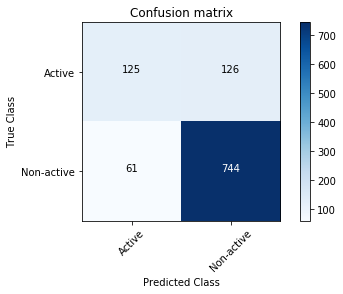

In [91]:
# Get predictions from a random forest classifier

def rf_predict_actual(data, n_estimators):
    # generate the features and targets
    features, targets = generate_features_targets(data)

    # instantiate a random forest classifier
    rfc = RandomForestClassifier(n_estimators=n_estimators)
  
    # get predictions using 10-fold cross validation with cross_val_predict
    predicted = cross_val_predict(rfc, features, targets, cv=10)

    # return the predictions and their actual classes
    return predicted, targets

    
# get the predicted and actual classes
number_estimators = 50    # Number of trees
predicted, actual = rf_predict_actual(data, number_estimators)

# calculate the model score using the calling the previously created function
accuracy = calculate_accuracy(predicted, actual)
print("Accuracy score:", accuracy)

# calculate the models confusion matrix using sklearns confusion_matrix function
class_labels = list(set(actual))
model_cm = confusion_matrix(y_true=actual, y_pred=predicted, labels=class_labels)

# plot the confusion matrix using the provided functions.
plt.figure()
plot_confusion_matrix(model_cm, classes=class_labels)
plt.savefig('rf_confusion_matrix.png')
plt.show();

Note; the Random Forest classifier is achieving a slightly higher overall accuracy, with:
* more *Active* predictions correct
* less misclassifications for the *Non-active* class

It is possible that if I had higher quality features, the difference would be more noticeable between the single Decision Tree and the Random Forest.

I would expect the predicted **Non-active** cohort that are actually **Active**, to have a higher probability of resigning in the foreseeable future.

In [92]:
# Print some initial results, including selected features
print("Some initial results...\n   predicted,  actual, Tenure, Age, Dept_Ratio, Amount")
for i in range(10):
    print("{}. {}, {}, {}, {}, {}, {}".format(i, predicted[i], actual[i],
                                          features[i, 0], features[i, 1], features[i, 2], features[i, 3]))

Some initial results...
   predicted,  actual, Tenure, Age, Dept_Ratio, Amount
0. Non-active, Non-active, 195.0, 22.0, 0.195, 20.1415
1. Non-active, Non-active, 2506.0, 26.0, 0.13, 23.3901
2. Non-active, Non-active, 566.0, 21.0, 0.155, 20.1415
3. Non-active, Non-active, 132.0, 20.0, 0.195, 20.1415
4. Non-active, Non-active, 199.0, 22.0, 0.016, 20.1415
5. Non-active, Active, 37.0, 36.0, 0.096, 20.1415
6. Non-active, Non-active, 375.0, 21.0, 0.027, 18.29
7. Active, Active, 212.0, 21.0, 0.13, 21.3228
8. Non-active, Non-active, 181.0, 33.0, 0.195, 20.1415
9. Non-active, Active, 51.0, 33.0, 0.155, 20.1415


I'm interested in the misclassifications where predicted class = *Non-active* and actual class = *Active*.

According to the above algorithms, these employees should have a higher likelihood of resigning in the future. With this in mind, lets take a quick look and export to a csv file if necessary.

Note: I tried to create a numpy array rather than a list, but ran into difficulties with a TypeError: "invalid type promotion". I decided to just use a list as it was easier with multiple data types.

In [93]:
# Create a list, convert to a dataframe and review.

# create empty list
errors = []

# loop through the output of the rf_predict_actual function for the errors of interest
for i in range(len(predicted)):
    
    if (predicted[i] == 'Non-active') & (actual[i] == 'Active'):
        errors.append([predicted[i], actual[i], features[i, 0], features[i, 1], features[i, 2], features[i, 3]])
                
# create a dataframe and set column names
error_df = pd.DataFrame(errors, columns=('predicted', 'actual', 'tenure', 'age', 'dept_ratio', 'amount'))

# take a look
print (error_df.head())
print (error_df.describe())   # count can be reconciled with the top-right quadrant of the confusion matrix

    predicted  actual  tenure   age  dept_ratio   amount
0  Non-active  Active    37.0  36.0       0.096  20.1415
1  Non-active  Active    51.0  33.0       0.155  20.1415
2  Non-active  Active   212.0  23.0       0.130  21.3228
3  Non-active  Active   714.0  33.0       0.006  42.5983
4  Non-active  Active   113.0  27.0       0.031  25.8709
             tenure         age  dept_ratio      amount
count    126.000000  126.000000  126.000000  126.000000
mean    1129.531746   30.817460    0.094873   24.957084
std     1735.264755   12.178933    0.061021    8.516662
min       16.000000   18.000000    0.001000   18.290000
25%      223.250000   22.000000    0.027000   20.141500
50%      621.500000   27.000000    0.099000   21.322800
75%     1147.000000   34.000000    0.130000   25.870900
max    10613.000000   73.000000    0.195000   79.326900


In [94]:
# Export errors to csv file for cataloguing if necessary.
from datetime import datetime

# create timestamp string
date_stamp = datetime.now().strftime('%d.%m.%Y')
# convert string to date time object and add column to error_df
error_df['date'] = pd.to_datetime(date_stamp)
# export to csv
error_df.to_csv('errors_' + date_stamp + '.csv', sep=',', index=False)

### Conclusion
From a business and in particular, a Human Resource department's perspective, this information can be useful to predict turnover rates. High turnover rates create issues such as:
* higher recruitment costs
* higher training costs
* decreased productivity (opportunity cost of HR resources not spending time on more value-adding tasks)
* lower engagement / morale
* lower knowledge base

The output from the above code cell could be re-joined to employee numbers and names to monitor. This would allow HR representatives and managers to target cultural change in areas where turnover is high. As with all predictions, an input variable, such as a new manager being employed in a high turnover department will change the output classifications.

One could argue, that the above information could be gleaned from simple exploratory data analysis (EDA). This is partly true, because this is a relatively simple dataset, however as the complexity increases, machine learning techniques such as Decision Tree algorithms will provide predictive value that would be difficult to attain otherwise.

References:
* Data-driven Astronomy: https://www.coursera.org/learn/data-driven-astronomy/home/welcome
* genfromtxt function: (https://docs.scipy.org/doc/numpy/reference/generated/numpy.genfromtxt.html)
* Seaborn pairplot: https://seaborn.pydata.org/generated/seaborn.pairplot.html
* Decision Tree documentation: http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
* Confusion Matrix: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
* Cross Validation: http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_predict.html
* Understanding Decision Trees and Random Forests: 
 * https://towardsdatascience.com/decision-trees-and-random-forests-for-classification-and-regression-pt-1-dbb65a458df
 * https://dataaspirant.com/2017/01/30/how-decision-tree-algorithm-works/
* Visualising Decision Trees:
 * https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176
 * https://www.youtube.com/watch?v=tNa99PG8hR8
* Categorical (string) features in scikit-learn Decision Trees: https://datascience.stackexchange.com/questions/5226/strings-as-features-in-decision-tree-random-forest